Install Packages

In [1]:
# ✅ Install necessary packages (only run once)
!pip install opencv-python-headless cupy-cuda12x --quiet



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Load image

In [3]:
import cv2
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from time import time

# 📤 Upload an image
# from google.colab import files
# uploaded = files.upload()

# 📚 Load image with OpenCV
#image_path = next(iter(uploaded))
image_path = "SobelFilter/large_image.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width = image.shape[:2]
print(f"Image size: {width}x{height}")


Image size: 3000x2000


Modify image to fit GPU required format

In [4]:
import cupy as cp
# Move image to GPU as a CuPy array
image_gpu = cp.asarray(image)

# Separate channels
r = image_gpu[:, :, 0]
g = image_gpu[:, :, 1]
b = image_gpu[:, :, 2]

# Convert to grayscale on GPU
# gray_gpu = cp.asarray(0.299 * r + 0.587 * g + 0.114 * b, dtype=cp.uint8)


Define GPU Sobel function

In [5]:
from cupyx.scipy.ndimage import convolve

def sobel_gpu(gray):
    # Sobel kernels
    Kx = cp.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=cp.float32)
    Ky = cp.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=cp.float32)

    # Convolve using CuPy (simulate with cv2 via CPU if needed)
    gx = convolve(gray, Kx)
    gy = convolve(gray, Ky)

    magnitude = np.sqrt(gx**2 + gy**2)
    magnitude = np.clip(magnitude, 0, 255).astype(np.uint8)
    return magnitude


Define CPU Sobel function

In [6]:
def sobel_cpu(gray_np):
    Kx = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
    Ky = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    gx = cv2.filter2D(gray_np, -1, Kx)
    gy = cv2.filter2D(gray_np, -1, Ky)
    magnitude = np.sqrt(gx**2 + gy**2)
    return np.clip(magnitude, 0, 255).astype(np.uint8)

# Use it:
gray_cpu = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
sobel_cpu_result = sobel_cpu(gray_cpu)


Execute both Sobels

In [11]:
# CPU version
start_cpu = time()
gray_cpu = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
sobel_cpu_result = sobel_cpu(gray_cpu)  # using the same function for fairness
end_cpu = time()

# GPU version
start_gpu = time()
gray_gpu = cp.asarray(0.299 * r + 0.587 * g + 0.114 * b, dtype=cp.uint8)
sobel_gpu_result = sobel_gpu(gray_gpu)
end_gpu = time()

print(f"CPU time: {(end_cpu - start_cpu)*1000:.2f} ms")
print(f"GPU time: {(end_gpu - start_gpu)*1000:.2f} ms")


CPU time: 138.03 ms
GPU time: 1.00 ms


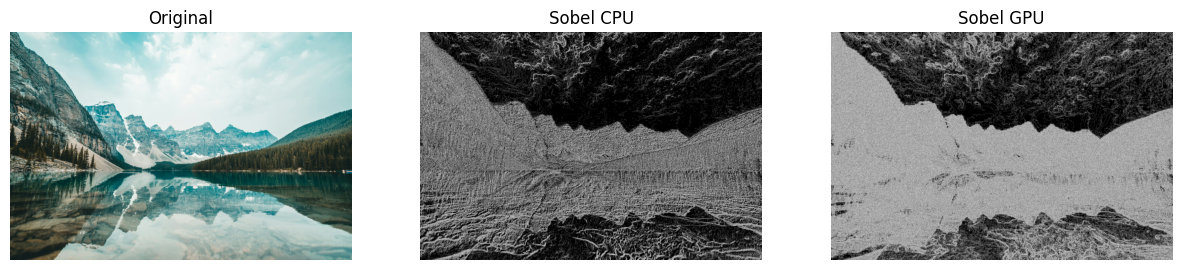

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(image)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Sobel CPU")
plt.imshow(sobel_cpu_result, cmap='gray')
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Sobel GPU")
# plt.imshow(sobel_gpu_result, cmap='gray')
plt.imshow(sobel_gpu_result.get(), cmap='gray')
plt.axis("off")

plt.show()
